In [2]:
import warnings
import pandas as pd
import numpy as np
import networkx as nx

from scipy import stats
from sklearn import preprocessing, metrics
from itertools import combinations

from news_vec.utils import read_json_gz_lines
from news_vec.encoder import read_preds

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [11]:
warnings.simplefilter('ignore')

In [12]:
def read_ava_test_df(pred_root):
    df, _ = read_preds(pred_root)
    return df[df.split=='test']

In [27]:
test = read_ava_test_df('../../data/ava-lstm/')

100%|██████████| 283/283 [00:13<00:00, 21.40it/s]


In [25]:
def build_ava_cm(pred_root, dst):
    
    df = read_ava_test_df(pred_root)
    domains = list(df.domain.unique())
    df['domain_pred'] = df.apply(lambda r: domains[np.argmax([r[f'p_{d}'] for d in domains])], 1)
    
    labels = list(df.domain.unique())
    cm = metrics.confusion_matrix(df.domain, df.domain_pred, labels=labels)
    
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure(figsize=(8,6), dpi=100)
    ax = sns.heatmap(cm_df, annot=True, fmt="d")
    ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.savefig(dst, bbox_inches='tight')

100%|██████████| 283/283 [00:12<00:00, 22.04it/s]


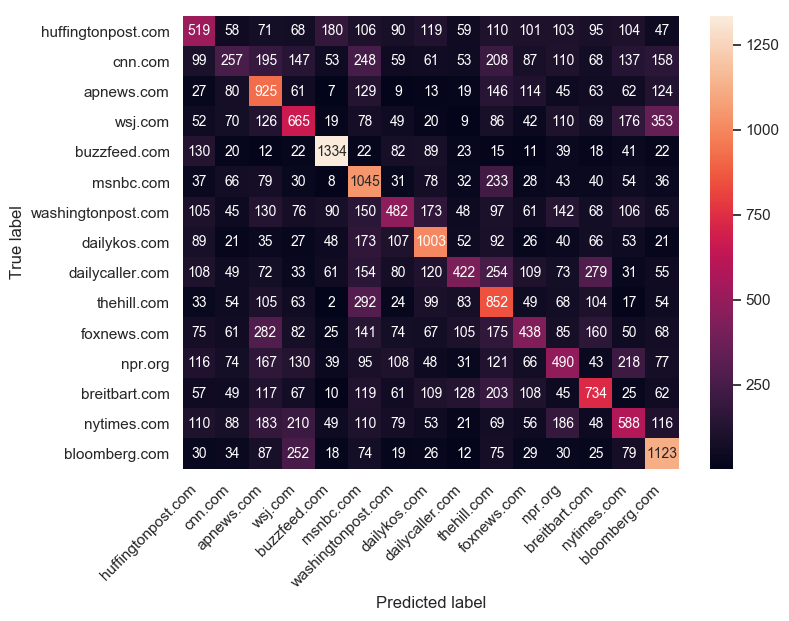

In [26]:
build_ava_cm('../../data/ava-lstm/', 'figures/lstm-cm.png')

In [30]:
lstm_test_df = read_ava_test_df('../../data/ava-lstm/')

100%|██████████| 283/283 [00:13<00:00, 20.53it/s]


In [37]:
', '.join(['%.5f' % w for w in lstm_test_df['p_wsj.com'].head(10)])

'0.00619, 0.17596, 0.03041, 0.01991, 0.00007, 0.01776, 0.01682, 0.00010, 0.00626, 0.09664'

In [38]:
', '.join(['%.5f' % w for w in lstm_test_df['p_bloomberg.com'].head(10)])

'0.00279, 0.49098, 0.00894, 0.00222, 0.00005, 0.00449, 0.00378, 0.00012, 0.00284, 0.02261'

# All-vs-all, confusion counts

In [39]:
def build_ava_cc_df(pred_root, prefix):
    
    df = read_ava_test_df(pred_root)
    domains = list(df.domain.unique())
    df['domain_pred'] = df.apply(lambda r: domains[np.argmax([r[f'p_{d}'] for d in domains])], 1)
    
    rows = []
    for d1 in domains:
        
        d2_count = df[df.domain==d1].groupby('domain_pred').size().to_dict()
    
        for d2, count in d2_count.items():
            if d2 != d1:
                rows.append((d1, d2, count))
    
    return pd.DataFrame(rows, columns=('d1', 'd2', f'{prefix}cc'))

In [40]:
lstm_cc = build_ava_cc_df('../../data/ava-lstm/', 'lstm_')

100%|██████████| 283/283 [00:13<00:00, 20.62it/s]


In [41]:
lstm_cc.sort_values('lstm_cc', ascending=False).head(10)

,d1,d2,lstm_cc
43,wsj.com,bloomberg.com,353
135,thehill.com,msnbc.com,292
140,foxnews.com,apnews.com,282
114,dailycaller.com,breitbart.com,279
123,dailycaller.com,thehill.com,254
209,bloomberg.com,wsj.com,252
22,cnn.com,msnbc.com,248
81,msnbc.com,thehill.com,233
164,npr.org,nytimes.com,218
195,nytimes.com,wsj.com,210


In [42]:
cnn_cc = build_ava_cc_df('../../data/ava-cnn-big/', 'cnn_')

100%|██████████| 283/283 [00:13<00:00, 20.79it/s]


In [43]:
cnn_cc.sort_values('cnn_cc', ascending=False).head(10)

,d1,d2,cnn_cc
135,thehill.com,msnbc.com,525
43,wsj.com,bloomberg.com,451
140,foxnews.com,apnews.com,447
22,cnn.com,msnbc.com,352
106,dailykos.com,msnbc.com,337
209,bloomberg.com,wsj.com,293
195,nytimes.com,wsj.com,277
120,dailycaller.com,msnbc.com,275
14,cnn.com,apnews.com,275
93,washingtonpost.com,msnbc.com,271


In [44]:
cbow_cc = build_ava_cc_df('../../data/ava-cbow/', 'cbow_')

100%|██████████| 283/283 [00:14<00:00, 20.15it/s]


In [45]:
cbow_cc.sort_values('cbow_cc', ascending=False).head(10)

,d1,d2,cbow_cc
209,bloomberg.com,wsj.com,385
114,dailycaller.com,breitbart.com,356
43,wsj.com,bloomberg.com,322
3,huffingtonpost.com,buzzfeed.com,287
140,foxnews.com,apnews.com,265
135,thehill.com,msnbc.com,257
142,foxnews.com,breitbart.com,232
34,apnews.com,foxnews.com,228
195,nytimes.com,wsj.com,227
128,thehill.com,breitbart.com,209


# All-vs-all, pcorr

In [46]:
def mirror_d1d2_iter(df):
    for r1 in df.to_dict('records'):
        yield r1
        r2 = r1.copy()
        r2['d1'], r2['d2'] = r2['d2'], r2['d1']
        yield r2

In [47]:
def mirror_d1d2(df):
    return pd.DataFrame(list(mirror_d1d2_iter(df)))

In [48]:
def build_ava_pcorr_df(pred_root, prefix):
    
    df = read_ava_test_df(pred_root)
    pairs = [sorted(p) for p in combinations(df.domain.unique(), 2)]
    
    rows = []
    for d1, d2 in pairs:
    
        p1 = df[f'p_{d1}']
        p2 = df[f'p_{d2}']

        sp, _ = stats.spearmanr(p1, p2)
        kt, _ = stats.kendalltau(p1, p2)
        pr, _ = stats.pearsonr(p1, p2)

        rows.append((d1, d2, sp, kt, pr))
        
    cols = ('d1', 'd2', f'{prefix}sp', f'{prefix}kt', f'{prefix}pr')
    res = pd.DataFrame(rows, columns=cols)
    
    return mirror_d1d2(res)

In [49]:
lstm_pcorr = build_ava_pcorr_df('../../data/ava-lstm/', 'lstm_pcorr_')

100%|██████████| 283/283 [00:13<00:00, 20.30it/s]


In [50]:
lstm_pcorr.sort_values('lstm_pcorr_kt', ascending=False).head(10)

,d1,d2,lstm_pcorr_kt,lstm_pcorr_pr,lstm_pcorr_sp
99,wsj.com,bloomberg.com,0.556100,0.257603,0.741932
98,bloomberg.com,wsj.com,0.556100,0.257603,0.741932
174,breitbart.com,dailycaller.com,0.519636,0.243212,0.705255
175,dailycaller.com,breitbart.com,0.519636,0.243212,0.705255
97,wsj.com,nytimes.com,0.486668,0.164710,0.668494
96,nytimes.com,wsj.com,0.486668,0.164710,0.668494
126,msnbc.com,thehill.com,0.481788,0.128143,0.665083
127,thehill.com,msnbc.com,0.481788,0.128143,0.665083
201,nytimes.com,npr.org,0.473431,0.224164,0.653396
200,npr.org,nytimes.com,0.473431,0.224164,0.653396


In [51]:
cnn_pcorr = build_ava_pcorr_df('../../data/ava-cnn-big/', 'cnn_pcorr_')

100%|██████████| 283/283 [00:12<00:00, 22.11it/s]


In [52]:
cnn_pcorr.sort_values('cnn_pcorr_kt', ascending=False).head(10)

,cnn_pcorr_kt,cnn_pcorr_pr,cnn_pcorr_sp,d1,d2
99,0.576242,0.394916,0.767493,wsj.com,bloomberg.com
98,0.576242,0.394916,0.767493,bloomberg.com,wsj.com
6,0.557512,0.141917,0.725658,buzzfeed.com,huffingtonpost.com
7,0.557512,0.141917,0.725658,huffingtonpost.com,buzzfeed.com
201,0.550243,0.350856,0.738213,nytimes.com,npr.org
200,0.550243,0.350856,0.738213,npr.org,nytimes.com
175,0.530032,0.289073,0.712272,dailycaller.com,breitbart.com
174,0.530032,0.289073,0.712272,breitbart.com,dailycaller.com
126,0.524843,0.230891,0.712221,msnbc.com,thehill.com
127,0.524843,0.230891,0.712221,thehill.com,msnbc.com


In [53]:
cbow_pcorr = build_ava_pcorr_df('../../data/ava-cbow/', 'cbow_pcorr_')

100%|██████████| 283/283 [00:14<00:00, 20.11it/s]


In [54]:
cbow_pcorr.sort_values('cbow_pcorr_kt', ascending=False).head(10)

,cbow_pcorr_kt,cbow_pcorr_pr,cbow_pcorr_sp,d1,d2
99,0.649152,0.581247,0.838633,wsj.com,bloomberg.com
98,0.649152,0.581247,0.838633,bloomberg.com,wsj.com
201,0.524353,0.423397,0.710882,nytimes.com,npr.org
200,0.524353,0.423397,0.710882,npr.org,nytimes.com
7,0.524248,0.232072,0.709984,huffingtonpost.com,buzzfeed.com
6,0.524248,0.232072,0.709984,buzzfeed.com,huffingtonpost.com
175,0.510685,0.392066,0.696504,dailycaller.com,breitbart.com
174,0.510685,0.392066,0.696504,breitbart.com,dailycaller.com
126,0.483489,0.303908,0.670869,msnbc.com,thehill.com
127,0.483489,0.303908,0.670869,thehill.com,msnbc.com


# A-vs-B, accuracy

In [55]:
ab_acc = pd.DataFrame(read_json_gz_lines('../../data/clf-ab-acc.json/'))
ab_acc = ab_acc.rename(columns={'acc_lr': 'lr_ab_acc', 'acc_svc': 'svc_ab_acc'})
ab_acc['label'] = ab_acc[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

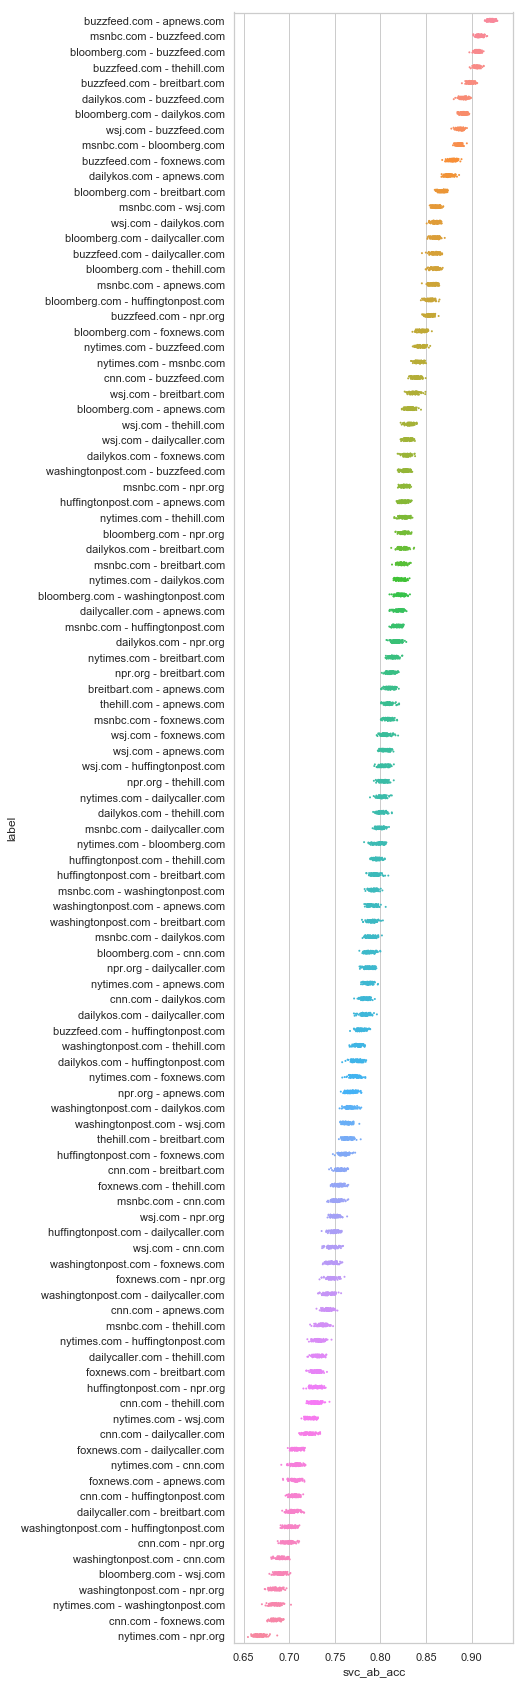

In [56]:
order = ab_acc.groupby('label').mean().svc_ab_acc.sort_values(ascending=False).index
plt.figure(figsize=(5,30))
sns.stripplot(x='svc_ab_acc', y='label', data=ab_acc, order=order, s=2)

In [57]:
ab_acc_mean = ab_acc.groupby(['d1', 'd2']).mean().reset_index()
ab_acc_mean = mirror_d1d2(ab_acc_mean)

In [58]:
ab_acc_mean.sort_values('svc_ab_acc').head(10)

,d1,d2,lr_ab_acc,svc_ab_acc
157,npr.org,nytimes.com,0.661674,0.667756
156,nytimes.com,npr.org,0.661674,0.667756
51,foxnews.com,cnn.com,0.675714,0.685090
50,cnn.com,foxnews.com,0.675714,0.685090
161,washingtonpost.com,nytimes.com,0.684811,0.685135
160,nytimes.com,washingtonpost.com,0.684811,0.685135
185,npr.org,washingtonpost.com,0.677927,0.685433
184,washingtonpost.com,npr.org,0.677927,0.685433
23,wsj.com,bloomberg.com,0.685407,0.690116
22,bloomberg.com,wsj.com,0.685407,0.690116


# A-vs-B, confusion

In [59]:
rows_lr, rows_svc = [], []
for r in read_json_gz_lines('../../data/clf-ab-cm.json'):
    rows_lr += r['cm_lr']
    rows_svc += r['cm_svc']

In [60]:
lr_ab_cc = pd.DataFrame(rows_lr)
svc_ab_cc = pd.DataFrame(rows_svc)

In [61]:
lr_ab_cc = lr_ab_cc.rename(columns={'count': 'lr_ab_cc'})
svc_ab_cc = svc_ab_cc.rename(columns={'count': 'svc_ab_cc'})

In [62]:
svc_ab_cc_mean = svc_ab_cc.groupby(['d1', 'd2']).mean().reset_index()
lr_ab_cc_mean = lr_ab_cc.groupby(['d1', 'd2']).mean().reset_index()

In [63]:
svc_ab_cc_mean.sort_values('svc_ab_cc', ascending=False).head(10)

,d1,d2,svc_ab_cc
68,cnn.com,washingtonpost.com,2187.51
166,nytimes.com,washingtonpost.com,2181.79
152,npr.org,washingtonpost.com,1973.93
63,cnn.com,huffingtonpost.com,1835.90
124,huffingtonpost.com,washingtonpost.com,1808.89
62,cnn.com,foxnews.com,1791.70
60,cnn.com,dailycaller.com,1780.71
197,wsj.com,bloomberg.com,1772.99
65,cnn.com,npr.org,1761.37
164,nytimes.com,npr.org,1752.33


# Combined metrics

In [64]:
df = (lstm_cc
    .merge(cnn_cc)
    .merge(cbow_cc)
    .merge(lstm_pcorr)
    .merge(cnn_pcorr)
    .merge(cbow_pcorr)
    .merge(ab_acc_mean)
    .merge(svc_ab_cc_mean)
    .merge(lr_ab_cc_mean))

In [65]:
metrics = set(df.columns) - {'d1', 'd2'}

Group on `d1`, scale scores with other outlets.

In [66]:
for col in metrics:
    df[col] = df.groupby('d1')[col].transform(preprocessing.scale)

Flip sign on accuracies.

In [67]:
for col in metrics:
    if col.endswith('_acc'):
        df[col] = -df[col]

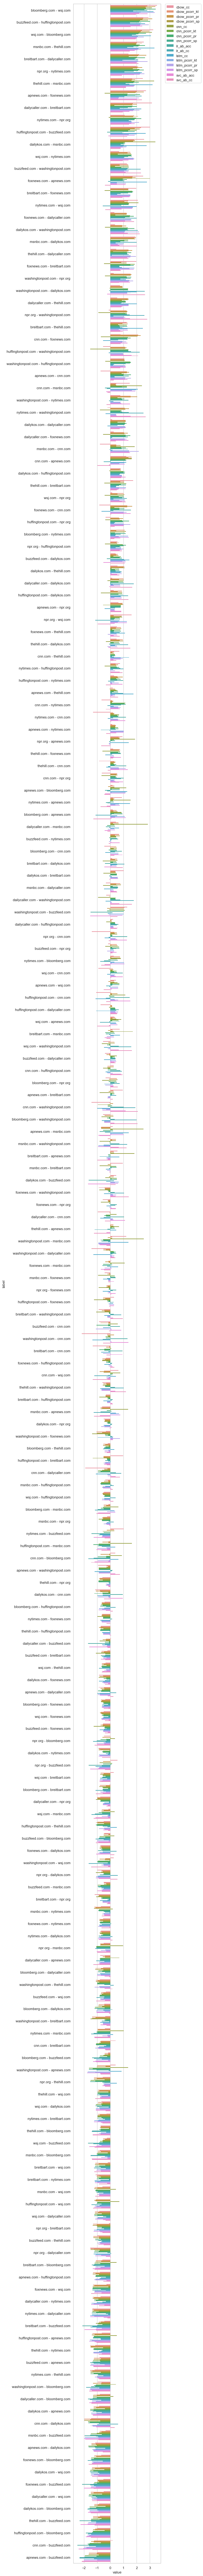

In [69]:
df_melted = df.melt(['d1', 'd2'], set(df.columns) - {'d1', 'd2'})
df_melted['label'] = df_melted[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)
df_melted = df_melted.sort_values('variable')

# Sort by mean score.
order = df_melted.groupby('label').mean().sort_values('value', ascending=False).index

plt.figure(figsize=(5,150))
ax = sns.barplot(x='value', y='label', data=df_melted, hue='variable', order=order, linewidth=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('figures/hl-graph-bars-all-metrics.png', bbox_inches='tight')

In [70]:
df.to_json('data/hl-graph.json', orient='records', lines=True)

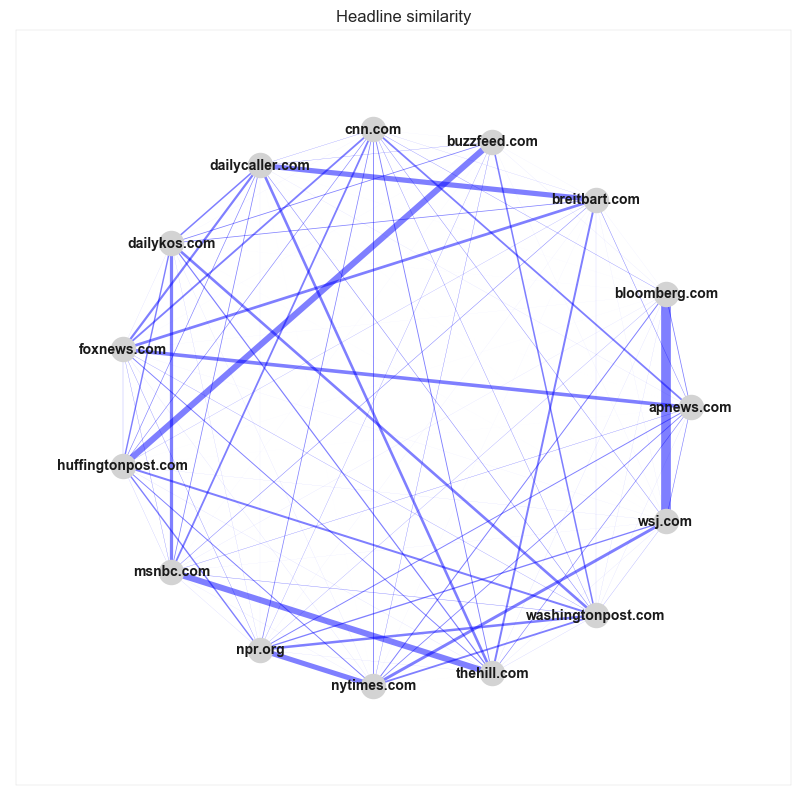

In [74]:
graph_df = df.copy()
graph_df['mean_score'] = graph_df.apply(lambda r: np.mean([r[m] for m in metrics]), 1)
graph_df['pair'] = graph_df.apply(lambda r: tuple(sorted([r.d1, r.d2])), 1)
graph_df = graph_df.groupby('pair').mean()
graph_df['width'] = (preprocessing.minmax_scale(graph_df.mean_score, (0,1))**3)*7

g = nx.Graph()
for r in graph_df.itertuples():
    g.add_edge(r.Index[0], r.Index[1], width=r.width)
    
edge_width = [d['width'] for _, _, d in g.edges(data=True)]

plt.figure(figsize=(10,10), dpi=100)
mpl.rc('axes', linewidth=0.2)
plt.xlim(-1.35,1.35)
plt.ylim(-1.35,1.35)
plt.xticks([])
plt.yticks([])
plt.title('Headline similarity')

pos = nx.layout.circular_layout(g)
nx.draw_networkx_nodes(g, pos, node_color='lightgray')
nx.draw_networkx_edges(g, pos, width=edge_width, alpha=0.5, edge_color='blue')
_ = nx.draw_networkx_labels(g, pos, font_weight='bold', font_size=10)
plt.savefig('figures/hl-graph-radial-all-metrics.png', bbox_inches='tight')